In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from keras.models import load_model
import warnings; warnings.simplefilter('ignore')

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


In [5]:
def read_box(window):
    window = cv2.bitwise_not(window)
    
    lineThickness = 1
    window = cv2.line(window, (0,0), (window.shape[1],0),1, lineThickness)
    window = cv2.line(window, (0,0), (0,window.shape[0]),1, lineThickness)
    window = cv2.line(window, (window.shape[1],0), (window.shape[1],window.shape[0]),1, lineThickness)
    window = cv2.line(window, (0,window.shape[0]), (window.shape[1],window.shape[0]),1, lineThickness)
    
    contours, h = cv2.findContours(window,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    full_area = window.shape[0] * window.shape[1]
    min_x = window.shape[1]
    min_y = window.shape[0]
    max_x = 0
    max_y = 0
    
    mask = np.ones(window.shape[:2], dtype="uint8")
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area <= 2:
            _ = cv2.drawContours(mask, [cnt], -1, 0, -1)
            continue
        rect = cv2.boundingRect(cnt)
        if (rect[2]*rect[3])/full_area >= 0.95: continue        
        if rect[3] == window.shape[0] or rect[2] == window.shape[1]:
            _ = cv2.drawContours(mask, [cnt], -1, 0, -1)
            continue
        if rect[0] < min_x:
            min_x = rect[0]
        if rect[0]+rect[2] > max_x:
            max_x = rect[0]+rect[2]
        if rect[1] < min_y:
            min_y = rect[1]
        if rect[1]+rect[3] > max_y:
            max_y = rect[1]+rect[3]
    digit_region = (min_x,min_y, max_x-min_x,max_y-min_y)
    max_rect = digit_region

    window = cv2.bitwise_and(window, window, mask=mask)
    window = window[max_rect[1]:max_rect[1]+max_rect[3], max_rect[0]:max_rect[0]+max_rect[2]]
    
    desired = 56
    if window.shape[0] < 28 and window.shape[1] < 28:
        desired = 28
    top = bottom = (desired - window.shape[0]) // 2
    left = right = (desired - window.shape[1]) // 2
    if top+bottom+window.shape[0] < desired:
        top += 1
    if left+right+window.shape[1] < desired:
        left += 1
    window = cv2.copyMakeBorder(window,top,bottom,left,right,cv2.BORDER_CONSTANT,0)

    if window.shape != (28,28):
        window = cv2.resize(window, (28,28), interpolation=cv2.INTER_AREA)
    return window

def adjust_borders(window):
    win = window.copy()
    w = win.shape[1]
    h = win.shape[0]
    
    # adjust left
    left_border = 0
    for i in range(10):
        filled = sum(win[:,i:i+1]!=0) / h
        if filled > 0.9: left_border = i+1
    win = win[:,left_border:]

    # adjust top
    top_border = 0
    for i in range(10):
        filled = (win[i:i+1,:]!=0).sum() / w
        if filled > 0.9: top_border = i+1
    win = win[top_border:,:]
    
    # adjust right
    right_border = 0
    for i in range(10):
        filled = sum(win[:,w-i-1:w-i]!=0) / h
        if filled > 0.9: right_border = i+1
    win = win[:,:w-right_border]
    
    # adjust bottom
    bottom_border = 0
    for i in range(10):
        filled = (win[h-i-1:h-i,:]!=0).sum() / w
        if filled > 0.9: bottom_border = i+1
    win = win[:h-bottom_border,:]

    return (left_border,top_border,right_border,bottom_border)

def get_boxes(window, topleft_xy,min_vertical,min_horizontal,minLineLength,maxLineGap,min_w,min_h):
    pivot_x, pivot_y = topleft_xy
    window_edges = cv2.Canny(window, 100, 150)
    lines = cv2.HoughLinesP(window_edges, 1, np.pi / 180, 15, np.array([]),minLineLength, maxLineGap)

    ys1 = []
    ys2 = []
    xs = [[],[],[],[]]
    for line in lines:
        ln = line[0]

        # vertical lines
        if abs(ln[0]-ln[2])<=3 and abs(ln[1]-ln[3]) >= min_vertical:
            if ln[0] < 0.36*window_edges.shape[1]:
                xs[0].append(ln[0])
            elif ln[0] < 0.6*window_edges.shape[1]:
                xs[1].append(ln[0])
            elif ln[0] < 0.83*window_edges.shape[1]:
                xs[2].append(ln[0])
            elif ln[0] > 0.89*window_edges.shape[1]:
                xs[3].append(ln[0])

        # horizontal lines
        if abs(ln[1]-ln[3])<=3 and abs(ln[0]-ln[2]) >= min_horizontal:
            if ln[1] < window_edges.shape[0]/2:
                ys1.append(ln[1])
            else:
                ys2.append(ln[1])
    y1 = max(ys1)
    y2 = min(ys2)

    boxes = [[],[],[]]
    if xs[0] and xs[1]:
        boxes[0] = [max(xs[0]), y1, abs(min(xs[1])-max(xs[0])), abs(y2-y1)]            
    if xs[1] and xs[2]:
        boxes[1] = [max(xs[1]), y1, abs(min(xs[2])-max(xs[1])), abs(y2-y1)]
    if xs[2] and xs[3]:
        boxes[2] = [max(xs[2]), y1, abs(min(xs[3])-max(xs[2])), abs(y2-y1)]
    
    # validate box width and height
    for i in range(3):
        if not boxes[i]: continue

        # validate box width 
        if boxes[i][2] < min_w-5 or boxes[i][2] > min_w+5:
            boxes[i][2] = min_w
        # validate box height
        if boxes[i][3] < min_h-5 or boxes[i][3] > min_h+5:
            boxes[i][3] = min_h

    if not boxes[0]:
        # missing left box
        if boxes[1]:
            boxes[0] = list(boxes[1])
            boxes[0][0] = boxes[1][0] - boxes[1][2]
        elif boxes[2]:
            boxes[0] = list(boxes[2])
            boxes[0][0] = boxes[2][0] - 2*boxes[2][2]
    if not boxes[1]:
        # missing middle box
        if boxes[0]:
            boxes[1] = list(boxes[0])
            boxes[1][0] = boxes[0][0] + boxes[0][2]
        elif boxes[2]:
            boxes[1] = list(boxes[2])
            boxes[1][0] = boxes[2][0] - boxes[2][2]

    if not boxes[2]:
        # missing right box
        if boxes[1]:
            boxes[2] = list(boxes[1])
            boxes[2][0] = boxes[1][0] + boxes[1][2]
        elif boxes[0]:
            boxes[2] = list(boxes[0])
            boxes[2][0] = boxes[0][0] + 2*boxes[0][2]

    # make sure there is no overlap between boxes horizontally
    if boxes[0] and boxes[1] and boxes[1][0] < boxes[0][0] + boxes[0][2]:
        boxes[1][0] = boxes[0][0] + boxes[0][2]
    if boxes[1] and boxes[2] and boxes[2][0] < boxes[1][0] + boxes[1][2]:
        boxes[2][0] = boxes[1][0] + boxes[1][2]

    # adjust boxes boundaries
    for box in boxes:
        if not box: continue
        
        (thresh, box_window_bw) = cv2.threshold(window, 215, 255, cv2.THRESH_BINARY)
        box_window = box_window_bw[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
        box_window = cv2.bitwise_not(box_window)
        
        w = box_window.shape[1]
        h = box_window.shape[0]
        (left,top,right,bottom) = adjust_borders(box_window)
        adjusted_box = box_window[top:h-bottom, left:w-right]
        box[0] += pivot_x+left
        box[1] += pivot_y+top
        box[2] = adjusted_box.shape[1]
        box[3] = adjusted_box.shape[0]

    return boxes    

def get_vote_box(window, topleft_xy,min_wh):
    min_w, min_h = min_wh
    return get_boxes(window, topleft_xy, 0.5*window.shape[0], 0.5*window.shape[1], 50, 20, min_w,min_h)

def get_ballot_box(window, topleft_xy,min_wh):
    min_w, min_h = min_wh
    return get_boxes(window, topleft_xy, 0.4*window.shape[0], 0.4*window.shape[1], 20, 10,min_w,min_h)

def get_squares(image_bw, min_side, max_side):
    contours, h = cv2.findContours(image_bw,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    full_area = image_bw.shape[0] * image_bw.shape[1]
    squares = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        rects = cv2.boundingRect(cnt)
        if area/full_area >= 0.9: continue
        if rects[2] < min_side or rects[3] < min_side: continue
        if rects[2] > max_side or rects[3] > max_side: continue            
        if abs(rects[3]-rects[2]) >= 2: continue
        squares.append(rects)
    return squares

def get_marker_box(window, min_side, max_side):
    thres = 250
    boxes = []
    min_box = ()
    min_area = max_side*max_side
    full_area = window.shape[0] * window.shape[1] * 255
    while thres > 100:
        (thres, window_bw) = cv2.threshold(window, thres, 255, cv2.THRESH_BINARY)
        boxes = get_squares(window_bw, min_side, max_side)
        if len(boxes) == 1:
            box_area = boxes[0][2]*boxes[0][3]
            occupied = window_bw.sum()/full_area
            if box_area < min_area and occupied >= 0.75:
                min_area = box_area
                min_box = boxes[0]
        thres -= 5
    return min_box

def find_markers(image, min_side, max_side):
    image_grayed = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    marker_w, marker_h = 100,100
    h = image.shape[0]
    w = image.shape[1]
    markers = {}
    
    # top-left marker
    pivot_x,pivot_y = (0,0)
    window = image_grayed[pivot_y:marker_h,pivot_x:marker_w]
    box = get_marker_box(window, min_side,max_side)
    if box:
        markers['top-left'] = (pivot_x+box[0],pivot_y+box[1],box[2],box[3])
    
    # bot-left marker
    pivot_x,pivot_y = 0, h-marker_h
    window = image_grayed[pivot_y:,pivot_x:marker_w]
    box = get_marker_box(window, min_side,max_side)
    if box:
        markers['bot-left'] = (pivot_x+box[0],pivot_y+box[1],box[2],box[3])

    # top-right marker
    pivot_x,pivot_y = (w-marker_w,0)
    window = image_grayed[pivot_y:marker_h,pivot_x:]
    box = get_marker_box(window, min_side,max_side)
    if box:
        markers['top-right'] = (pivot_x+box[0],pivot_y+box[1],box[2],box[3])
        
    # bot-right marker
    pivot_x,pivot_y = (w-marker_w,h-marker_h)
    window = image_grayed[pivot_y:,pivot_x:]
    box = get_marker_box(window, min_side,max_side)
    if box:
        markers['bot-right'] = (pivot_x+box[0],pivot_y+box[1],box[2],box[3])        
        
    if len(markers) == 3:
        if 'top-left' not in markers:
            dy = markers['bot-right'][1] - markers['bot-left'][1]
            dx = markers['bot-right'][0] - markers['bot-left'][0]
            tl_x = markers['top-right'][0] - dx
            tl_y = markers['top-right'][1] - dy
            markers['top-left']=(tl_x,tl_y,28,28)
        elif 'top-right' not in markers:
            dy = markers['bot-right'][1] - markers['bot-left'][1]
            dx = markers['bot-right'][0] - markers['bot-left'][0]
            tr_x = markers['top-left'][0] + dx
            tr_y = markers['top-left'][1] + dy
            markers['top-right']=(tr_x,tr_y,28,28)
        elif 'bot-left' not in markers:
            dy = markers['top-right'][1] - markers['top-left'][1]
            dx = markers['top-right'][0] - markers['top-left'][0]
            bl_x = markers['bot-right'][0] - dx
            bl_y = markers['bot-right'][1] - dy
            markers['bot-left']=(bl_x,bl_y,28,28)
        elif 'bot-right' not in markers:
            dy = markers['top-right'][1] - markers['top-left'][1]
            dx = markers['top-right'][0] - markers['top-left'][0]
            br_x = markers['bot-left'][0] + dx
            br_y = markers['bot-left'][1] + dy
            markers['bot-right']=(br_x,br_y,28,28)
    return markers

def scan_boxes(boxes, boxes_window_bw):
    count_str = ''
    confidence = True
    boxes28 = []
    for box in boxes:
        window = boxes_window_bw[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]        
        window = read_box(window)
        boxes28.append(window)
        if window.sum() < 10:
            char = '0'
            count_str += '0'
            continue
        window = window.reshape((1, 28, 28, 1))
        
        pred = model_hyphen.predict_classes(window)
        if pred[0] == 1:
            char = '-'
        else:
            pred = modelX.predict_classes(window)
            if pred[0] == 1:
                char = 'X'
            else:
                pred = model_digits.predict_classes(window)[0]
                pred2 = model.predict_classes(window)[0]
                if pred != pred2:
                    confidence = False
                char = str(pred)
        count_str += char

    if count_str[2] == 'X':
        count_str = 'XXX'
    elif count_str[1] == 'X':
        count_str = 'X' + count_str[1:]

    return count_str, confidence, boxes28

def scan_form(img_file, img_file_out):
    # ### Load Formulir-C1 Scanned Images
    image = mpimg.imread(img_file)

    # ### Find 4 box markers
    markers = find_markers(image, min_side=20, max_side=50)
    if len(markers) != 4: raise Exception("Unable to read form: %s" % img_file)

    # ## Perspective Transform based on Markers
    pts = [markers[x][:2] for x in markers]
    pts = np.array(pts, dtype = "float32")
    trans_img = four_point_transform(image, pts)
    trans_img_grayed = cv2.cvtColor(trans_img, cv2.COLOR_RGB2GRAY)

    form_height = trans_img.shape[0]
    form_width = trans_img.shape[1]

    # ### Get votes boxes
    pivot_x, pivot_y = round(form_width*0.8),round(form_height*0.14)
    window = trans_img_grayed[pivot_y:round(form_height*0.29),pivot_x:]
    min_w = round(form_width*0.04)
    min_h = round(form_height*0.05)
    
    win01 = window[:window.shape[0]//2,:]
    boxes01 = get_vote_box(win01, (pivot_x,pivot_y), (min_w,min_h))
    if not all(boxes01): raise Exception("Unable to read form: %s" % img_file)

    win02 = window[window.shape[0]//2:,:]
    boxes02 = get_vote_box(win02, (pivot_x,pivot_y+window.shape[0]//2),(min_w,min_h))
    if not all(boxes02): raise Exception("Unable to read form: %s" % img_file)

    # ### Get ballots boxes
    pivot_x, pivot_y = round(form_width*0.8),round(form_height*0.37)
    window = trans_img_grayed[pivot_y:round(form_height*0.55),pivot_x:]
    min_w = round(form_width*0.041)
    min_h = round(form_height*0.025)

    win_valid = window[:round(0.23*window.shape[0]),:]
    win_invalid = window[round(0.37*window.shape[0]):round(0.65*window.shape[0]),:]
    win_total = window[round(0.78*window.shape[0]):,:]

    boxes_valid = get_ballot_box(win_valid,(pivot_x, pivot_y),(min_w,min_h))
    if not all(boxes_valid): raise Exception("Unable to read form: %s" % img_file)

    boxes_invalid = get_ballot_box(win_invalid,(pivot_x, round(0.37*window.shape[0])+pivot_y),(min_w,min_h))
    if not all(boxes_invalid): raise Exception("Unable to read form: %s" % img_file)

    boxes_total = get_ballot_box(win_total,(pivot_x, round(0.78*window.shape[0])+pivot_y),(min_w,min_h))
    if not all(boxes_total): raise Exception("Unable to read form: %s" % img_file)

    # ### Read hand written digits
    confidence = {'votes01':True,'votes02':True,'valid_ballots':True,'invalid_ballots':True,'total_ballots':True}
    validity = {k:False for k in confidence}

    clone = trans_img.copy()
    clone_grayed = cv2.cvtColor(clone, cv2.COLOR_RGB2GRAY)
    (thresh, clone_bw) = cv2.threshold(clone_grayed, 215, 255, cv2.THRESH_BINARY)

    suara01, confidence['votes01'], digits_01 = scan_boxes(boxes01, clone_bw)
    suara02, confidence['votes02'], digits_02 = scan_boxes(boxes02, clone_bw)
    suara_sah,confidence['valid_ballots'], digits_valid = scan_boxes(boxes_valid, clone_bw)
    suara_tidak_sah,confidence['invalid_ballots'], digits_invalid  = scan_boxes(boxes_invalid, clone_bw)
    total_suara,confidence['total_ballots'], digits_total = scan_boxes(boxes_total, clone_bw)

    # ## Validation and correction
    try:
        votes01 = int(suara01.replace('X','0'))
        votes02 = int(suara02.replace('X','0'))
        nb_valid = int(suara_sah.replace('X','0'))
        nb_invalid = int(suara_tidak_sah.replace('X','0'))
        nb_total = int(total_suara.replace('X','0'))        
    except:
        raise Exception("Unable to read form: %s" % img_file)

    if nb_valid == votes01 + votes02:
        validity['votes01'] = validity['votes02'] = validity['valid_ballots'] = True
    if nb_total == nb_invalid + nb_valid:
        validity['valid_ballots'] = validity['invalid_ballots'] = validity['total_ballots'] = True
    if nb_total == votes01 + votes02 - nb_invalid:
        validity['votes01'] = validity['votes02'] = validity['invalid_ballots'] = validity['total_ballots'] = True
    valid_conf = {x:validity[x] or confidence[x] for x in validity}

    if not valid_conf['votes01'] and valid_conf['votes02'] and valid_conf['valid_ballots']:
        votes01 = nb_valid-votes02
        valid_conf['votes01'] = True

    if not valid_conf['votes02'] and valid_conf['votes01'] and valid_conf['valid_ballots']:
        votes02 = nb_valid - votes01
        valid_conf['votes02'] = True

    # one value still invalid or low confidence
    if sum(valid_conf.values())==4:
        if not valid_conf['valid_ballots']:
            nb_valid = votes01 + votes02
            valid_conf['valid_ballots'] = True

        if not valid_conf['invalid_ballots']:
            nb_invalid = nb_total - nb_valid
            valid_conf['invalid_ballots'] = True
            
        if not valid_conf['total_ballots']:
            nb_total = nb_valid + nb_invalid
            valid_conf['total_ballots'] = True

    # ### Draw CNN 28x28 digits
    digit_box = [(digits_01,boxes01),(digits_02,boxes02),(digits_valid,boxes_valid),(digits_invalid,boxes_invalid),(digits_total,boxes_total)]
    for digits, boxes in digit_box:
        width = boxes[2][0]+boxes[2][2] - boxes[0][0]
        for j, box in enumerate(boxes):
            s_img = digits[j]
            x_offset=box[0] - width
            y_offset=box[1]-45
            clone_grayed[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img

    # convert back to RGB
    clone = cv2.cvtColor(clone_grayed,cv2.COLOR_GRAY2RGB)

    # ### Draw boxes
    for box in (boxes01+boxes02+boxes_valid+boxes_invalid+boxes_total):
        _ = cv2.rectangle(clone, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0,255,0), 2)

    # ## Draw numbers
    count_box = [(votes01,boxes01),(votes02,boxes02),(nb_valid,boxes_valid),(nb_invalid,boxes_invalid),(nb_total,boxes_total)]
    for count, boxes in count_box:
        count_str = str(count).zfill(3)
        for j, box in enumerate(boxes):
            char = count_str[j]
            _ = cv2.rectangle(clone, (box[0],box[1]-45), (box[0]+30,box[1]-5), (0, 0, 255), -1) 
            _ = cv2.putText(clone,char,(box[0],box[1]-10), cv2.FONT_HERSHEY_PLAIN,3,(255,255,255),2)

    # ## Save image
    mpimg.imsave(img_file_out,clone)

    return (votes01, votes02, nb_valid, nb_invalid, nb_total)

In [6]:
# copyright: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
 
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
 
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
 
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
 
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
 
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
 
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
    # return the warped image
    return warped


### Load Classifiers

In [33]:
model = load_model('classifiers/digits_recognizer.h5')
model_digits = load_model('classifiers/mnist_classifier.h5')
model_hyphen = load_model('classifiers/hyphen_classifier.h5')
modelX = load_model('classifiers/X_classifier.h5')

### Load Formulir-C1 Scanned Images

In [34]:
img_file = 'test_images/test2.jpg'
image = mpimg.imread(img_file)

### Find 4 box markers

In [35]:
markers = find_markers(image, min_side=20, max_side=50)
markers

{'top-left': (44, 55, 28, 29),
 'bot-left': (39, 1676, 28, 29),
 'top-right': (1143, 58, 28, 29),
 'bot-right': (1134, 1679, 29, 30)}

## Perspective Transform based on Markers

In [36]:
pts = [markers[x][:2] for x in markers]
pts = np.array(pts, dtype = "float32")
trans_img = four_point_transform(image, pts)
trans_img_grayed = cv2.cvtColor(trans_img, cv2.COLOR_RGB2GRAY)

In [37]:
form_height = trans_img.shape[0]
form_width = trans_img.shape[1]
form_width,form_height

(1099, 1621)

### Get vote count boxes

In [38]:
pivot_x, pivot_y = round(form_width*0.8),round(form_height*0.14)
window = trans_img_grayed[pivot_y:round(form_height*0.29),pivot_x:]
min_w = round(form_width*0.04)
min_h = round(form_height*0.05)

In [39]:
# Candidate #01
win01 = window[:window.shape[0]//2,:]
boxes01 = get_vote_box(win01, (pivot_x,pivot_y), (min_w,min_h))
# Candidate #02
win02 = window[window.shape[0]//2:,:]
boxes02 = get_vote_box(win02, (pivot_x,pivot_y+window.shape[0]//2), (min_w,min_h))

### Get ballot count boxes

In [40]:
pivot_x, pivot_y = round(form_width*0.8),round(form_height*0.37)
window = trans_img_grayed[pivot_y:round(form_height*0.55),pivot_x:]
min_w = round(form_width*0.041)
min_h = round(form_height*0.025)

In [41]:
win_valid = window[:round(0.23*window.shape[0]),:]
win_invalid = window[round(0.37*window.shape[0]):round(0.65*window.shape[0]),:]
win_total = window[round(0.78*window.shape[0]):,:]

In [42]:
boxes_valid = get_ballot_box(win_valid,(pivot_x, pivot_y),(min_w,min_h))
boxes_invalid = get_ballot_box(win_invalid,(pivot_x, round(0.37*window.shape[0])+pivot_y),(min_w,min_h))
boxes_total = get_ballot_box(win_total,(pivot_x, round(0.78*window.shape[0])+pivot_y), (min_w,min_h))

### Read vote counts

In [43]:
confidence = {'votes01':True,'votes02':True,'valid_ballots':True,'invalid_ballots':True,'total_ballots':True}
validity = {k:False for k in confidence}

In [44]:
clone = trans_img.copy()
clone_grayed = cv2.cvtColor(clone, cv2.COLOR_RGB2GRAY)
(thresh, clone_bw) = cv2.threshold(clone_grayed, 215, 255, cv2.THRESH_BINARY)

In [45]:
suara01, confidence['votes01'], digits_01 = scan_boxes(boxes01, clone_bw)
suara02, confidence['votes02'], digits_02 = scan_boxes(boxes02, clone_bw)
suara_sah,confidence['valid_ballots'], digits_valid = scan_boxes(boxes_valid, clone_bw)
suara_tidak_sah,confidence['invalid_ballots'], digits_invalid  = scan_boxes(boxes_invalid, clone_bw)
total_suara,confidence['total_ballots'], digits_total = scan_boxes(boxes_total, clone_bw)

## Validation

In [46]:
try:
    votes01 = int(suara01.replace('X','0'))
    votes02 = int(suara02.replace('X','0'))
    nb_valid = int(suara_sah.replace('X','0'))
    nb_invalid = int(suara_tidak_sah.replace('X','0'))
    nb_total = int(total_suara.replace('X','0'))        
except:
    raise Exception("Unable to read form: %s" % img_file)

In [47]:
if nb_valid == votes01 + votes02:
    validity['votes01'] = validity['votes02'] = validity['valid_ballots'] = True
if nb_total == nb_invalid + nb_valid:
    validity['valid_ballots'] = validity['invalid_ballots'] = validity['total_ballots'] = True
if nb_total == votes01 + votes02 - nb_invalid:
    validity['votes01'] = validity['votes02'] = validity['invalid_ballots'] = validity['total_ballots'] = True

In [48]:
valid_conf = {x:validity[x] or confidence[x] for x in validity}

In [49]:
if not valid_conf['votes01'] and valid_conf['votes02'] and valid_conf['valid_ballots']:
    votes01 = nb_valid-votes02
    valid_conf['votes01'] = True

if not valid_conf['votes02'] and valid_conf['votes01'] and valid_conf['valid_ballots']:
    votes02 = nb_valid - votes01
    valid_conf['votes02'] = True

# one value still invalid or low confidence
if sum(valid_conf.values())==4:
    if not valid_conf['valid_ballots']:
        nb_valid = votes01 + votes02
        valid_conf['valid_ballots'] = True

    if not valid_conf['invalid_ballots']:
        nb_invalid = nb_total - nb_valid
        valid_conf['invalid_ballots'] = True

    if not valid_conf['total_ballots']:
        nb_total = nb_valid + nb_invalid
        valid_conf['total_ballots'] = True

## Draw CNN 28x28 digits

In [50]:
digit_box = [(digits_01,boxes01),(digits_02,boxes02),
    (digits_valid,boxes_valid),(digits_invalid,boxes_invalid),(digits_total,boxes_total)]
for digits, boxes in digit_box:
    width = boxes[2][0]+boxes[2][2] - boxes[0][0]
    for j, box in enumerate(boxes):
        s_img = digits[j]
        x_offset=box[0] - width
        y_offset=box[1]-45
        clone_grayed[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img

# convert back to RGB
clone = cv2.cvtColor(clone_grayed,cv2.COLOR_GRAY2RGB)

## Draw boxes

In [51]:
for box in (boxes01+boxes02+boxes_valid+boxes_invalid+boxes_total):
    _ = cv2.rectangle(clone, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0,255,0), 2)

## Draw numbers and rectangles

In [52]:
count_box = [(votes01,boxes01),(votes02,boxes02),
    (nb_valid,boxes_valid),(nb_invalid,boxes_invalid),(nb_total,boxes_total)]
for count, boxes in count_box:
    count_str = str(count).zfill(3)
    for j, box in enumerate(boxes):
        char = count_str[j]
        _ = cv2.rectangle(clone, (box[0],box[1]-45), (box[0]+30,box[1]-5), (0, 0, 255), -1) 
        _ = cv2.putText(clone,char,(box[0],box[1]-10), cv2.FONT_HERSHEY_PLAIN,3,(255,255,255),2)


## Show image

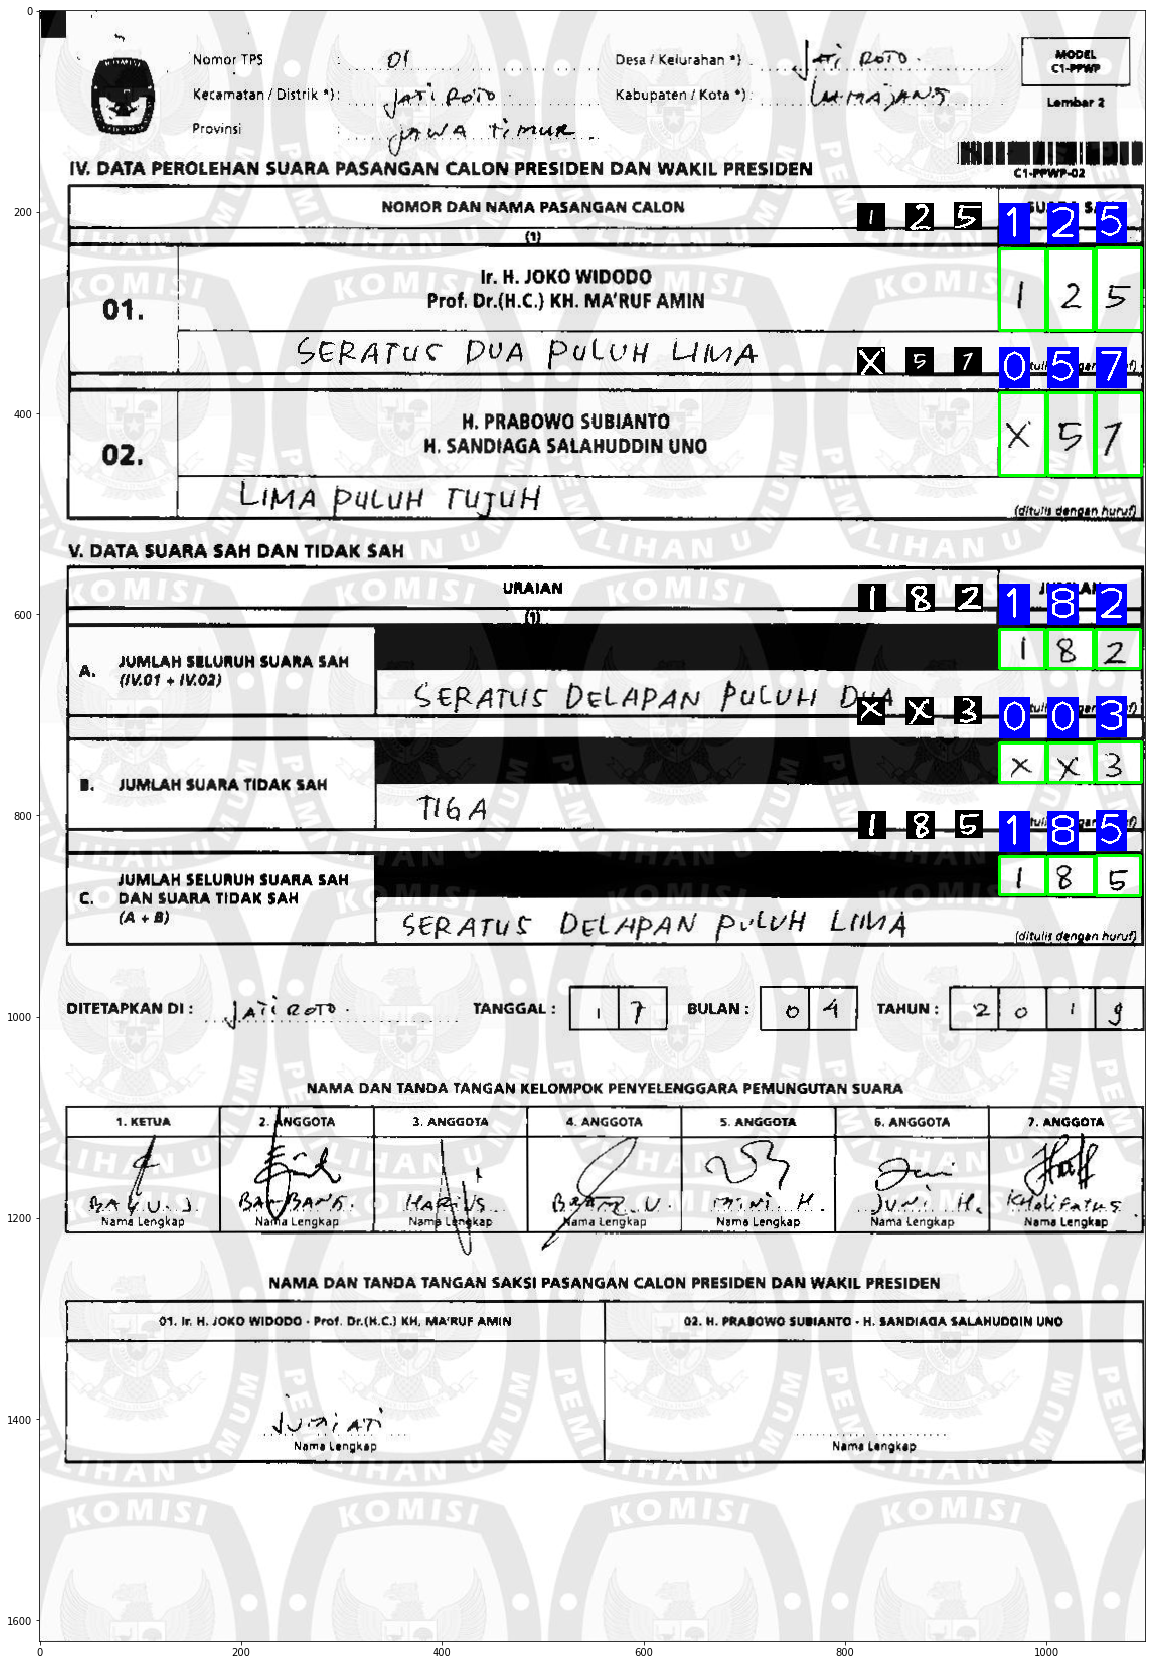

In [53]:
fig, ax = plt.subplots(figsize=(30, 30))
ax.imshow(clone)